# Genotype quality control

This tutorial explores typical genotype quality control metrics, including allele frequency distribution, linkage disequilibrium and methods to test for population structure.

## Allele frequency distribution

Allele frequency has profound implications for the genetic effects that can be identifeid. Here, we explore allele frequency distributions in multiple datasets, which differ in terms of their underlying genetic designs.

The example below shows how some basic statistics can be obtained for genotype data in a yeast cross (Bloom et al., Nature 2013).

The task:

Explore allele frequency distributions in other datasets, including data from 1000 genomes and A. thaliana. 
What are the implications for genotype-to-phenotype mapping ?

* What are the advantages and disadvantages of partiular genetic designs ?  
* Both to detect associations with common and rare variants ? 
* Why do some datasets have allele frequencies [0..0.5] and others [0..1] ?

In [1]:
import IPython
print IPython.sys_info()

{'commit_hash': u'f534027',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/IPython',
 'ipython_version': '4.0.0',
 'os_name': 'posix',
 'platform': 'Darwin-14.5.0-x86_64-i386-64bit',
 'sys_executable': '/Users/davis/anaconda/envs/py2.7/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '2.7.10 |Continuum Analytics, Inc.| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]'}


In [2]:
import tables

In [4]:
# activiate inline plotting
%matplotlib inline
from setup import *

In [5]:
#import data: BYxRM cross
#import data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line tool
file_name = tutorial_data.get_file('BYxRM')
geno_reader_BYxRM  = gr.genotype_reader_tables(file_name)
# M is a binary matrix [samples,genotypes]
MBYxRM = geno_reader_BYxRM.getGenotypes()
posBYxRM = geno_reader_BYxRM.getPos()['pos']

#import data: 1000 genomes
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
genotype_file = tutorial_data.get_file('1000g')
annotation_file = tutorial_data.get_file('1000g_annotation')
geno_reader_1000G  = gr.genotype_reader_tables(genotype_file)
#read annotation
fa = h5py.File(annotation_file,'r')
population_1000G = fa['Population'][:]
#select YRI and CEU populations
Ipop = (population_1000G=='CEU') | (population_1000G=='YRI')


population_1000G = population_1000G[Ipop]
M1000G = geno_reader_1000G.getGenotypes()[Ipop]
pos1000G = geno_reader_1000G.getPos()['pos']
#note: the 1000g samples have different populational background.
#a subset of the samples are Yerubuan (YRI) and the remaining are Central European (EU)
#you can query this information using the array "popuatlion_1000G"

#import data: Arabidopsis
#import data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
file_name = tutorial_data.get_file('arab107')
geno_reader_atwell  = gr.genotype_reader_tables(file_name)
Matwell = geno_reader_atwell.getGenotypes()
posatwell = geno_reader_atwell.getPos()['pos']


In [6]:
MBYxRM

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [7]:
#strains in the yeast cross are homozygous, which is encoded [0,1] - [ref/ref,alt/alt]
#for heterozygous systems, we need to set minor=2 as the encoding is [0,1,2] - [ref/ref,ref/alt,alt/alt]
afBYxRM  = (MBYxRM==1).mean(0)
af1000G  = 0.5*M1000G.mean(0) #0.5*(2*(M1000G==2)+1*(M1000G==1)).mean(0)
afatwell = 0.5*Matwell.mean(0) #0.5*(2*(Matwell==2)+1*(Matwell==1)).mean(0)

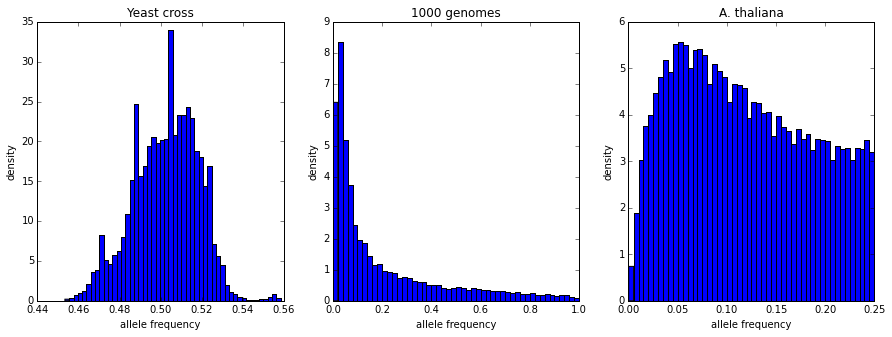

In [8]:
pl.figure(figsize=[15,5])

plt.subplot(1,3,1)
plot=pl.hist(afBYxRM,50,normed=True)
pl.ylabel('density')
pl.title('Yeast cross')
pl.xlabel('allele frequency')

##cut
plt.subplot(1,3,2)
plot=pl.hist(af1000G,50,normed=True)
pl.ylabel('density')
pl.title('1000 genomes')
pl.xlabel('allele frequency')

plt.subplot(1,3,3)
plot=pl.hist(afatwell,50,normed=True)
pl.ylabel('density')
pl.title('A. thaliana')
pl.xlabel('allele frequency')



## Linkage disequilibrium

The resolution of genotype to phenotype mapping is affect by linkage disequilibrium. We here explore the correlation between nearby genetic markers as a function of distance.

Tasks:

* How does the minor allele frequency affect LD?
* How to global and local correlations compare and are related to differences in the genetic designs ? 
* Is there long-range LD and if yes, what might be causes for this effect ? 

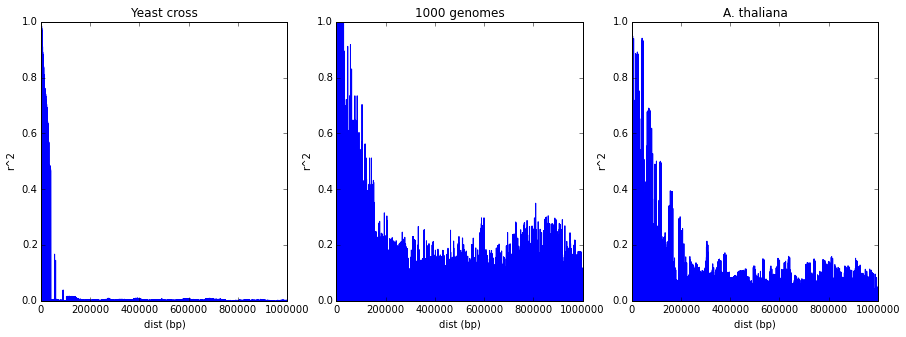

In [9]:
#Local LD plots

pl.figure(figsize=[15,5])

plt.subplot(1,3,1)
LDByxRM = calc_LD(MBYxRM,posBYxRM.values)
pl.plot(LDByxRM[0],LDByxRM[1])
pl.ylabel('r^2')
pl.xlabel('dist (bp)')
pl.title('Yeast cross')

#the calc_LD function has an optional parameter i_start, determining from how many positions the sampling started.
#you can use this to improve the resolution. try i_start=sp.arange(10) or i_start=sp.arange(100)

## CUT
maf = 0.01
plt.subplot(1,3,2)
Iaf = af1000G>=maf
LDp = calc_LD(M1000G[:,Iaf],pos1000G.values[Iaf],i_start=sp.arange(100))
pl.plot(LDp[0],LDp[1])
pl.ylabel('r^2')
pl.xlabel('dist (bp)')
pl.title('1000 genomes')


plt.subplot(1,3,3)
Iaf = afatwell>=maf
LDp = calc_LD(Matwell[:,Iaf],posatwell.values[Iaf],i_start=sp.arange(10))
pl.plot(LDp[0],LDp[1])
pl.ylabel('r^2')
pl.xlabel('dist (bp)')
pl.title('A. thaliana')


## Population structure

Principal component analysis can be used to reveal particular relationship between samples. We here apply PCA to multiple different datasets to explore the extent of population structure.

Tasks:
* Apply PCA to the yeast cross, the Arabidopsis data and 1000 genomes data.
* Do you see clusters witin the data? 
* If yes, what do these clusters corresond to ? 

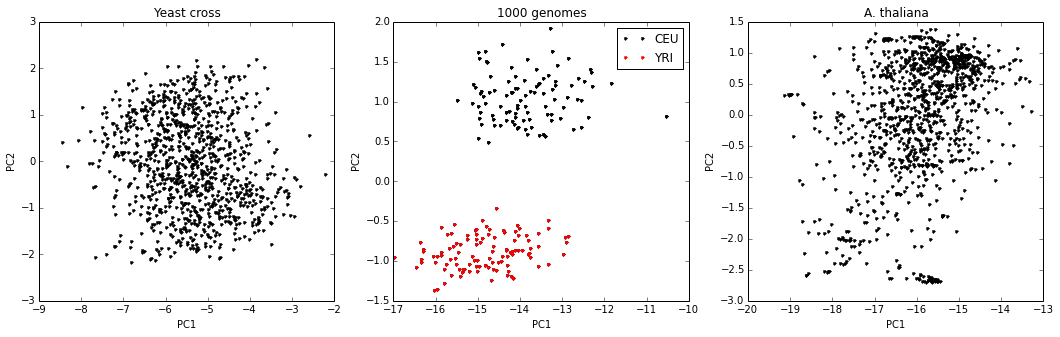

In [13]:
# PCA

import limix.stats.pca as pca

pl.figure(figsize=[18,5])

plt.subplot(1,3,1)
[snpsX,snpsW] = pca.PCA(MBYxRM[:,0:5000],components=10)
pl.plot(snpsX[:,0],snpsX[:,1],'k.')
pl.xlabel('PC1')
pl.ylabel('PC2')
pl.title('Yeast cross')

## cut
plt.subplot(1,3,2)
[snpsX,snpsW] = pca.PCA(M1000G[:,0:5000],components=10)
pl.plot(snpsX[:,0],snpsX[:,1],'k.')
ICEU = (population_1000G=='CEU')
IYRI = (population_1000G=='YRI')

pl.plot(snpsX[:,0][ICEU],snpsX[:,1][ICEU],'k.',label='CEU')
pl.plot(snpsX[:,0][IYRI],snpsX[:,1][IYRI],'r.',label='YRI')
pl.xlabel('PC1')
pl.ylabel('PC2')
pl.legend()
pl.title('1000 genomes')


plt.subplot(1,3,3)
[snpsX,snpsW] = pca.PCA(Matwell[:,0:5000],components=10)
pl.plot(snpsX[:,0],snpsX[:,1],'k.')
pl.xlabel('PC1')
pl.ylabel('PC2')
pl.title('A. thaliana')